# Interactive Beam Demo

## Requirement

1. Install [graphviz](https://graphviz.gitlab.io/) via `apt install graphviz` or `conda install -c anaconda graphviz`
2. Install [graphviz Python library](https://github.com/xflr6/graphviz) via `pip install graphviz`

In [0]:
!pip install apache_beam
!apt-get install graphviz
!pip install graphviz

In [1]:
import apache_beam as beam
from apache_beam.runners.interactive import interactive_runner
from apache_beam.runners.direct import direct_runner

interactive_runner.SAMPLE_SIZE = 8

In [2]:
import time
@beam.ptransform_fn
def Sleep(pcoll, secs):
    return (pcoll
            | beam.Map(lambda x: (None, x))
            | beam.GroupByKey()
            | beam.Map(lambda kvs: time.sleep(secs) or kvs)
            | beam.FlatMap(lambda (k, vs): vs))

In [3]:
p = beam.Pipeline(runner=interactive_runner.InteractiveRunner(
    underlying_runner=direct_runner.BundleBasedDirectRunner()))

init_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
init_pcoll = p |  beam.Create(init_list) | Sleep(2)
squares_pcoll = init_pcoll | 'Square' >> beam.Map(lambda x: x*x)
cubes_pcoll = init_pcoll | 'Cube' >> beam.Map(lambda x: x**3)

result = p.run(False)

Running...

Using 0 cached PCollections
Executing 9 of 9 transforms.

Create produced {8, 1, 6, 3, 2, ...}

Sleep(2)/Map(<lambda at <ipython-input-2-c11a5999ca56>:5>) produced {(None, 3), (None, 9), (None, 1), (None, 10), (None, 8), ...}

Sleep(2)/GroupByKey/ReifyWindows produced {(None, (7, MIN_TIMESTAMP, [GlobalWi..., (None, (2, MIN_TIMESTAMP, [GlobalWi..., (None, (3, MIN_TIMESTAMP, [GlobalWi..., (None, (8, MIN_TIMESTAMP, [GlobalWi..., (None, (10, MIN_TIMESTAMP, [GlobalW..., ...}

Sleep(2)/GroupByKey/GroupByKey produced {(None, [(1, MIN_TIMESTAMP, [GlobalW...}

Sleep(2)/GroupByKey produced {(None, [1, 2, 3, 4, 5, 6, 7, 8, 9, ...}

Sleep(2)/Map(<lambda at <ipython-input-2-c11a5999ca56>:7>) produced {(None, [1, 2, 3, 4, 5, 6, 7, 8, 9, ...}

Sleep(2)/FlatMap(<lambda at <ipython-input-2-c11a5999ca56>:8>) produced {2, 10, 9, 5, 8, ...}

Cube produced {729, 125, 343, 1000, 27, ...}

Square produced {36, 25, 49, 16, 81, ...}

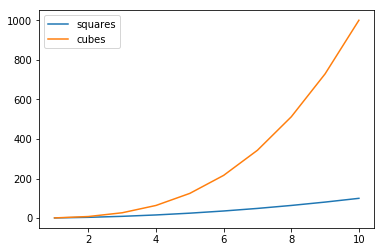

In [4]:
squares_list = list(result.get(squares_pcoll))
cubes_list = list(result.get(cubes_pcoll))

%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(init_list, squares_list, label='squares')
plt.plot(init_list, cubes_list, label='cubes')
plt.legend(loc='best')  # To show the label

In [5]:
class AverageFn(beam.CombineFn):
  def create_accumulator(self):
    return (0.0, 0)

  def add_input(self, sum_count, input):
    (sum, count) = sum_count
    return sum + input, count + 1

  def merge_accumulators(self, accumulators):
    sums, counts = zip(*accumulators)
    return sum(sums), sum(counts)

  def extract_output(self, sum_count):
    (sum, count) = sum_count
    return sum / count if count else float('NaN')

In [6]:
average_sq_pcoll = squares_pcoll | 'Average' >> beam.CombineGlobally(AverageFn())
result = p.run(False)

Running...

Using 1 cached PCollections
Executing 8 of 17 transforms.

Square produced {36, 25, 49, 16, 81, ...}

Average/DoOnce produced {None}

Average/KeyWithVoid produced {(None, 81), (None, 16), (None, 64), (None, 4), (None, 36), ...}

Average/CombinePerKey/GroupByKey/ReifyWindows produced {(None, (49, MIN_TIMESTAMP, [GlobalW..., (None, (36, MIN_TIMESTAMP, [GlobalW..., (None, (16, MIN_TIMESTAMP, [GlobalW..., (None, (64, MIN_TIMESTAMP, [GlobalW..., (None, (4, MIN_TIMESTAMP, [GlobalWi..., ...}

Average/CombinePerKey/GroupByKey/GroupByKey produced {(None, [(1, MIN_TIMESTAMP, [GlobalW...}

Average/CombinePerKey/GroupByKey produced {(None, [1, 4, 9, 16, 25, 36, 49, 64...}

Average/CombinePerKey/Combine/ParDo(CombineValuesDoFn) produced {(None, 38.5)}

Average/UnKey produced {38.5}

Average/InjectDefault produced {38.5}

In [7]:
class SumFn(beam.CombineFn):
  def create_accumulator(self):
    return 0.0

  def add_input(self, sum, input):
    return sum + input

  def merge_accumulators(self, accumulators):
    return sum(accumulators)

  def extract_output(self, sum):
    return sum

In [8]:
sum_sq_pcoll = squares_pcoll | 'Sum' >> beam.CombineGlobally(SumFn())
result = p.run(False)

Running...

Using 1 cached PCollections
Executing 8 of 25 transforms.

Sum/CombinePerKey/GroupByKey/GroupByKey produced {(None, [(1, MIN_TIMESTAMP, [GlobalW...}

Sum/CombinePerKey/GroupByKey produced {(None, [1, 4, 9, 16, 25, 36, 49, 64...}

Sum/KeyWithVoid produced {(None, 81), (None, 16), (None, 64), (None, 4), (None, 36), ...}

Sum/CombinePerKey/GroupByKey/ReifyWindows produced {(None, (49, MIN_TIMESTAMP, [GlobalW..., (None, (36, MIN_TIMESTAMP, [GlobalW..., (None, (16, MIN_TIMESTAMP, [GlobalW..., (None, (64, MIN_TIMESTAMP, [GlobalW..., (None, (4, MIN_TIMESTAMP, [GlobalWi..., ...}

Sum/DoOnce produced {None}

Square produced {36, 25, 49, 16, 81, ...}

Sum/CombinePerKey/Combine produced {(None, 385.0)}

Sum/UnKey produced {385.0}

Sum produced {385.0}

In [9]:
print(list(result.get(squares_pcoll)))
print(list(result.get(average_sq_pcoll)))
print(list(result.get(sum_sq_pcoll)))

[1, 4, 9, 16, 25, 36, 49, 64, 81, 100]
[38.5]
[385.0]
